In [1]:
import os
import numpy as np
import librosa
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Conv1D, BatchNormalization, MaxPooling1D,
    Bidirectional, LSTM, Dropout, Dense, Lambda, Layer, Masking
)
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import random
import warnings
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Percorsi dei file
SAVE_DIR    = r"...GLOBAL_FILE = os.path.join(SAVE_DIR, "emovo_global_features.xlsx")
LOCAL_FILE  = os.path.join(SAVE_DIR, "emovo_local_features.xlsx")

# Caricamento dei dati
df_global = pd.read_excel(GLOBAL_FILE)
df_local  = pd.read_excel(LOCAL_FILE)

# Ottienimento di tutte le utterance
utterances_all = df_global[['file', 'emotion']].drop_duplicates()

# Suddivisione fissa: 59 train, 12 val, 13 test per emozione
train_list, val_list, test_list = [], [], []

for emotion in df_global['emotion'].unique():
    emo_utts = utterances_all[utterances_all['emotion'] == emotion].sample(frac=1, random_state=44).reset_index(drop=True)
    
    if len(emo_utts) < 84:
        raise ValueError(f"⚠️ Emozione '{emotion}' ha solo {len(emo_utts)} utteranze (servono almeno 84).")
    
    train_list.append(emo_utts.iloc[:59])
    val_list.append(emo_utts.iloc[59:71])
    test_list.append(emo_utts.iloc[71:84])

# Combinazione
train_utts = pd.concat(train_list).reset_index(drop=True)
val_utts   = pd.concat(val_list).reset_index(drop=True)
test_utts  = pd.concat(test_list).reset_index(drop=True)

# Liste dei file
train_files = train_utts['file'].tolist()
val_files   = val_utts['file'].tolist()
test_files  = test_utts['file'].tolist()

# Creazione dei set finali

# Local features
l_train_u = df_local[df_local['file'].isin(train_files)].reset_index(drop=True)
l_val_u   = df_local[df_local['file'].isin(val_files)].reset_index(drop=True)
l_test_u  = df_local[df_local['file'].isin(test_files)].reset_index(drop=True)

# Normalizzazione per speaker
def normalize_df_per_speaker(df, feature_cols):
    scalers = {}
    df_norm = df.copy()
    for speaker in df['speaker'].unique():
        df_speaker = df[df['speaker'] == speaker]
        scaler = StandardScaler()
        scaler.fit(df_speaker[feature_cols])
        scalers[speaker] = scaler
        df_norm.loc[df_speaker.index, feature_cols] = scaler.transform(df_speaker[feature_cols])
    return df_norm, scalers

# Selezionamento delle colonne numeriche da normalizzare
non_feature_cols = ['file', 'emotion', 'speaker', 'utt_id', 'frame']
local_feature_cols  = [col for col in l_train_u.columns if col not in non_feature_cols]

# Local features
l_train_u, l_scalers = normalize_df_per_speaker(l_train_u, local_feature_cols)
l_val_u,   _         = normalize_df_per_speaker(l_val_u, local_feature_cols)
l_test_u,  _         = normalize_df_per_speaker(l_test_u, local_feature_cols)

# Verifiche
print(f"Local features:  train={len(l_train_u)},  val={len(l_val_u)},  test={len(l_test_u)}")

print(train_utts.shape, val_utts.shape)
print("Train emotions:", train_utts['emotion'].value_counts())
print("Val emotions:", val_utts['emotion'].value_counts())
print("Test emotions:", test_utts['emotion'].value_counts())

print("\nSpeaker distribution in Local sets:")
print("Train:", l_train_u['speaker'].value_counts().to_dict())
print("Val  :", l_val_u['speaker'].value_counts().to_dict())
print("Test :", l_test_u['speaker'].value_counts().to_dict())

Local features:  train=163629,  val=32059,  test=34081
(413, 2) (84, 2)
Train emotions: emotion
Anger        59
Disgust      59
Fear         59
Happiness    59
Neutral      59
Sadness      59
Surprise     59
Name: count, dtype: int64
Val emotions: emotion
Anger        12
Disgust      12
Fear         12
Happiness    12
Neutral      12
Sadness      12
Surprise     12
Name: count, dtype: int64
Test emotions: emotion
Anger        13
Disgust      13
Fear         13
Happiness    13
Neutral      13
Sadness      13
Surprise     13
Name: count, dtype: int64

Speaker distribution in Local sets:
Train: {'m1': 30798, 'f3': 30673, 'f1': 29742, 'm3': 26536, 'f2': 23589, 'm2': 22291}
Val  : {'m2': 9972, 'f1': 7803, 'f3': 4377, 'm3': 4275, 'f2': 3359, 'm1': 2273}
Test : {'m1': 9035, 'f2': 7163, 'm2': 6538, 'm3': 5836, 'f3': 3730, 'f1': 1779}


In [3]:
# Preparazione sequenze
def prepare_sequences(df, feature_cols, maxlen=None, le=None):
    grouped = df.groupby("file")
    X, y_labels = [], []
    for fname, grp in grouped:
        grp = grp.sort_values("frame")
        X.append(grp[feature_cols].values)
        y_labels.append(grp["emotion"].iloc[0])
    if le is None:
        le = LabelEncoder()
        y_enc = le.fit_transform(y_labels)
    else:
        y_enc = le.transform(y_labels)
    y_cat = to_categorical(y_enc)
    if maxlen is None:
        maxlen = max(len(x) for x in X)
    X_pad = pad_sequences(X, maxlen=maxlen, padding="post", dtype="float32")
    return X_pad, y_cat, le, maxlen

feature_cols = [c for c in l_train_u.columns if c.startswith("mfcc") or 
                                                 c.startswith("logmel") or 
                                                 c.startswith("dmfcc") or 
                                                 c.startswith("dlogmel")]

X_train, y_train, label_enc, MAXLEN = prepare_sequences(l_train_u, feature_cols)
X_val,   y_val,   _,         _      = prepare_sequences(l_val_u, feature_cols, maxlen=MAXLEN, le=label_enc)
X_test,  y_test,  _,         _      = prepare_sequences(l_test_u, feature_cols, maxlen=MAXLEN, le=label_enc)

# Calcolo dei pesi delle classi
num_classes = y_train.shape[1]
cw = compute_class_weight("balanced", classes=np.arange(num_classes), y=np.argmax(y_train, axis=1))
class_weight = {i: float(w * 0.5) for i, w in enumerate(cw)}

# Livello di attenzione additiva
class AdditiveAttentionLayer(Layer):
    def __init__(self, units=64, **kwargs):
        super().__init__(**kwargs)
        self.d1 = Dense(units, activation="tanh")
        self.d2 = Dense(1)
        self.sm = tf.keras.layers.Softmax(axis=1)
    def call(self, inputs):
        s = self.d1(inputs)
        s = self.d2(s)
        w = self.sm(s)
        return tf.reduce_sum(inputs * w, axis=1)

# Modello
inp = Input(shape=(MAXLEN, len(feature_cols)))

# CNN
x = Conv1D(64, 5, padding="same", activation="relu")(inp)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Conv1D(64, 5, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

# BLSTM
mask = Lambda(lambda t: tf.math.reduce_any(tf.not_equal(t, 0.0), axis=-1))(inp)
x = Bidirectional(LSTM(128, return_sequences=True))(x, mask=mask)
x = Dropout(0.5)(x)

# Attention + Dense
x = AdditiveAttentionLayer(units=64)(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(1e-3), name="dense_embed")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output
out = Dense(num_classes, activation="softmax")(x)

# Compilazione
model = Model(inputs=inp, outputs=out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


# Addestramento del Modello
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau("val_loss", factor=0.5, patience=4, min_lr=1e-8, verbose=1),
    tf.keras.callbacks.EarlyStopping("val_loss", patience=15, restore_best_weights=True, verbose=1)
]
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=16,
                    class_weight=class_weight,
                    callbacks=callbacks, verbose=2)

# Valutazione del Modello
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f}, Test loss: {test_loss:.3f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1129, 46)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1129, 64)  │     14,784 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1129, 64)  │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 564, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 564, 64)   │     20,544 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 564, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 282, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1129)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 282, 256)  │    197,632 │ max_pooling1d_1[… │
│ (Bidirectional)     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 282, 256)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention… │ (None, 256)       │     16,513 │ dropout[0][0]     │
│ (AdditiveAttention… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_embed (Dense) │ (None, 64)        │     16,448 │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_embed[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7)         │        455 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 267,144 (1.02 MB)

 Trainable params: 266,760 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
26/26 - 11s - 423ms/step - accuracy: 0.1743 - loss: 1.1608 - val_accuracy: 0.1429 - val_loss: 2.0440 - learning_rate: 1.0000e-04
Epoch 2/100
26/26 - 4s - 155ms/step - accuracy: 0.3099 - loss: 1.0026 - val_accuracy: 0.2381 - val_loss: 2.0353 - learning_rate: 1.0000e-04
Epoch 3/100
26/26 - 5s - 206ms/step - accuracy: 0.3366 - loss: 0.9470 - val_accuracy: 0.2619 - val_loss: 2.0249 - learning_rate: 1.0000e-04
Epoch 4/100
26/26 - 6s - 231ms/step - accuracy: 0.3705 - loss: 0.8726 - val_accuracy: 0.3452 - val_loss: 2.0109 - learning_rate: 1.0000e-04
Epoch 5/100
26/26 - 6s - 221ms/step - accuracy: 0.3995 - loss: 0.8276 - val_accuracy: 0.4167 - val_loss: 1.9893 - learning_rate: 1.0000e-04
Epoch 6/100
26/26 - 5s - 185ms/step - accuracy: 0.4552 - loss: 0.7956 - val_accuracy: 0.3929 - val_loss: 1.9688 - learning_rate: 1.0000e-04
Epoch 7/100
26/26 - 5s - 198ms/step - accuracy: 0.5085 - loss: 0.7467 - val_accuracy: 0.4881 - val_loss: 1.9366 - learning_rate: 1.0000e-04
Epoch 8/100
26/26 -

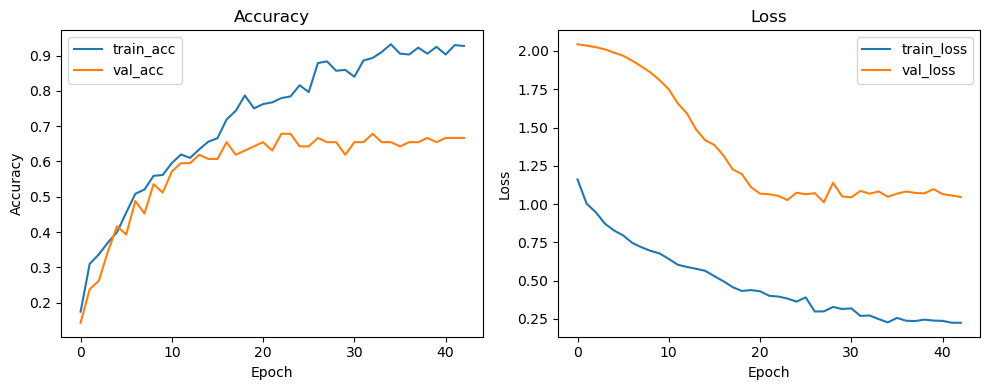


✅ Test accuracy: 0.725  –  loss: 0.999
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step


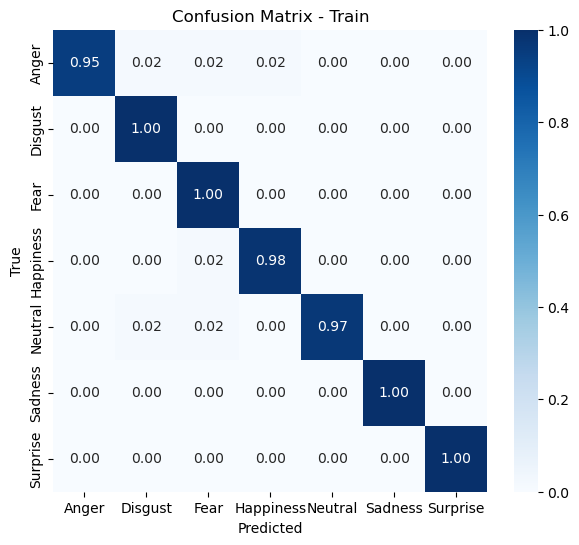

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


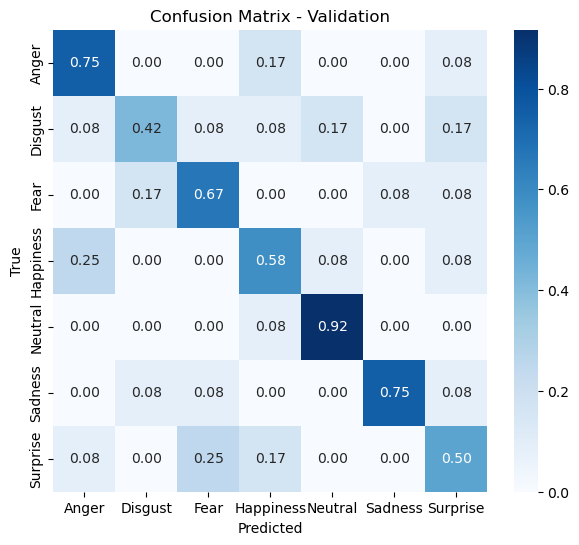

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


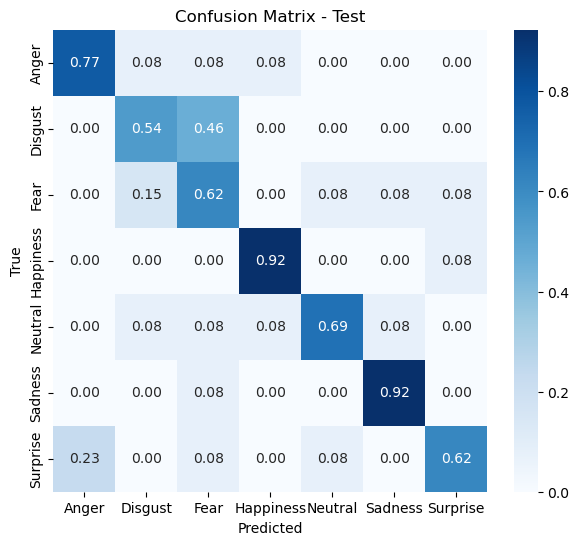

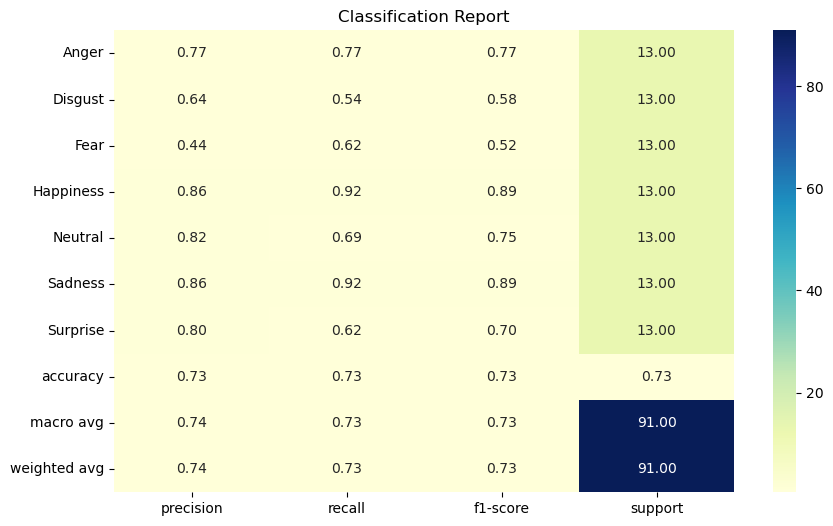

In [4]:
# CURVE Accuracy & Loss
plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Valutazione su Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test accuracy: {test_acc:.3f}  –  loss: {test_loss:.3f}")

# Codifica delle classi
label_names = label_enc.classes_

# Funzione per matrici normalizzate
def plot_conf_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, normalize='true')  # percentuali riga per riga
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Confusion Matrix - TRAIN
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_train_true = np.argmax(y_train, axis=1)
plot_conf_matrix(y_train_true, y_train_pred, label_names, 'Confusion Matrix - Train')

# Confusion Matrix - VALIDATION
y_val_pred = np.argmax(model.predict(X_val), axis=1)
y_val_true = np.argmax(y_val, axis=1)
plot_conf_matrix(y_val_true, y_val_pred, label_names, 'Confusion Matrix - Validation')

# Confusion Matrix - TEST
y_test_pred = np.argmax(model.predict(X_test), axis=1)
y_test_true = np.argmax(y_test, axis=1)
plot_conf_matrix(y_test_true, y_test_pred, label_names, 'Confusion Matrix - Test')

# CLASSIFICATION REPORT
report_dict = classification_report(
    y_test_true,
    y_test_pred,
    target_names=label_names,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

# Heatmap
report_df_filtered = report_df
heatmap_data = report_df_filtered

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Classification Report")
plt.show()


Addestrato HMM per 'Anger' con 15 stati, log-likelihood: -1139573.80
Addestrato HMM per 'Disgust' con 15 stati, log-likelihood: -1205677.60
Addestrato HMM per 'Fear' con 15 stati, log-likelihood: -981623.10
Addestrato HMM per 'Happiness' con 15 stati, log-likelihood: -1036749.55
Addestrato HMM per 'Neutral' con 15 stati, log-likelihood: -1109263.11
Addestrato HMM per 'Sadness' con 15 stati, log-likelihood: -885008.13
Addestrato HMM per 'Surprise' con 15 stati, log-likelihood: -1020263.92


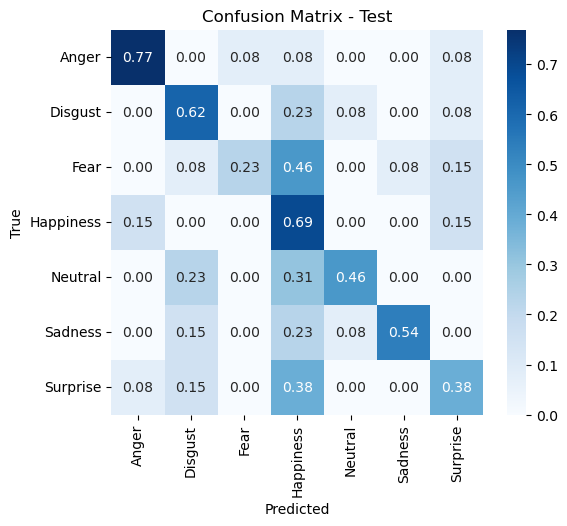

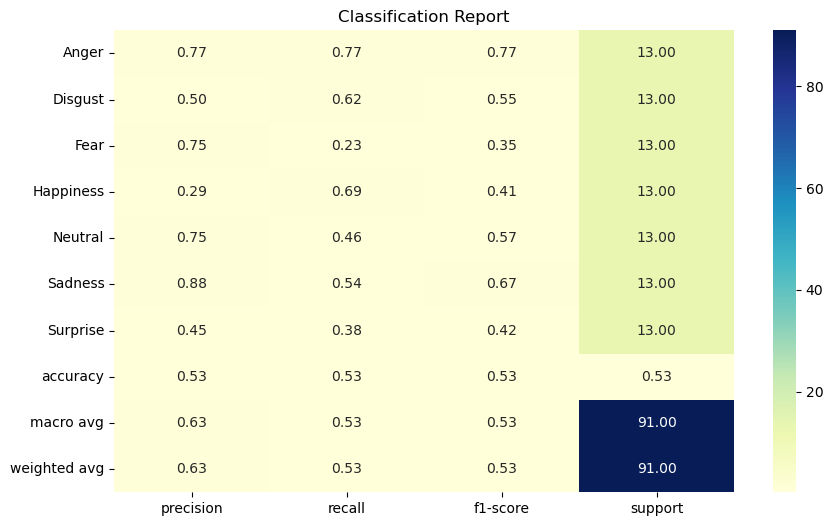

In [5]:
feature_cols = [
    c for c in l_train_u.columns
    if c.startswith("mfcc") or c.startswith("logmel")
    or c.startswith("dmfcc") or c.startswith("dlogmel")
]

def prepare_hmm_sequences(df, feature_cols, le=None):
    grouped = df.groupby("file")
    sequences, labels = [], []
    for fname, grp in grouped:
        grp = grp.sort_values("frame")
        feats = grp[feature_cols].values.astype(np.float32)
        sequences.append(feats)
        labels.append(grp["emotion"].iloc[0])
    if le is None:
        le = LabelEncoder()
        y = le.fit_transform(labels)
    else:
        y = le.transform(labels)

    return sequences, y, le

# Unione train + validation
l_trainval_u = pd.concat([l_train_u, l_val_u], ignore_index=True)
X_train_seq, y_train, label_enc = prepare_hmm_sequences(l_trainval_u, feature_cols)
X_test_seq,  y_test,  _         = prepare_hmm_sequences(l_test_u,  feature_cols, le=label_enc)

# Addestramento Gaussian HMM per emozione
models = {}
for idx, emo in enumerate(label_enc.classes_):
    seqs = [X_train_seq[i] for i in range(len(y_train)) if y_train[i] == idx]
    lengths = [len(s) for s in seqs]
    concat = np.vstack(seqs)

    best_score = -np.inf
    best_model = None

    for _ in range(5):  # Più inizializzazioni
        model = hmm.GaussianHMM(
            n_components=15,
            covariance_type='diag',
            n_iter=200,
            random_state=np.random.randint(0, 10000)
        )
        try:
            model.fit(concat, lengths)
            score = model.score(concat, lengths)
            if score > best_score:
                best_score = score
                best_model = model
        except:
            continue

    models[emo] = best_model
    print(f"Addestrato HMM per '{emo}' con 15 stati, log-likelihood: {best_score:.2f}")

# Predizione & Valutazione
def predict_hmm(models, sequences):
    preds = []
    for seq in sequences:
        scores = {}
        for emo, m in models.items():
            try:
                score = m.score(seq)
                scores[emo] = score
            except:
                scores[emo] = -np.inf
        pred_emo = max(scores, key=scores.get)
        preds.append(pred_emo)
    return label_enc.transform(preds)

# Predizioni numeriche
y_test_pred_idx = predict_hmm(models, X_test_seq)
y_test_true_idx = y_test

# Matrice di confusione normalizzata
cm = confusion_matrix(y_test_true_idx, y_test_pred_idx, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".2f",
            xticklabels=label_enc.classes_,
            yticklabels=label_enc.classes_,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test')
plt.show()

# CLASSIFICATION REPORT
report_dict = classification_report(
    y_test_true_idx,
    y_test_pred_idx,
    target_names=label_enc.classes_,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

# Heatmap
report_df_filtered = report_df
heatmap_data = report_df_filtered

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Classification Report")
plt.show()